## Initial Setup and Directory Creation
This cell imports Python libraries and sets up the initial directory structure for the KITTI dataset. It creates a base directory called 'kitti_dataset' and defines URLs for downloading the KITTI object detection dataset images and labels.

In [1]:
import os
import requests
from tqdm import tqdm
import zipfile
import glob
import cv2
import random
import shutil
from pathlib import Path

# Base directory for the dataset
DATASET_DIR = "kitti_dataset"
os.makedirs(DATASET_DIR, exist_ok=True)

# KITTI dataset URLs
KITTI_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip"
LABELS_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip"

print("Libraries imported and directories set up!")

Libraries imported and directories set up!


## Dataset Download
This cell defines a function to download files with a progress bar and uses it to download the KITTI dataset images and labels from the specified URLs into the created directory.

In [ ]:
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    file_size = int(response.headers.get('content-length', 0))
    block_size = 1024
    with open(dest_path, "wb") as file, tqdm(
        desc=dest_path,
        total=file_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(block_size):
            bar.update(len(data))
            file.write(data)
    print(f"Downloaded: {dest_path}")

# Downloading images
image_zip = os.path.join(DATASET_DIR, "data_object_image_2.zip")
download_file(KITTI_URL, image_zip)

# Downloading labels
labels_zip = os.path.join(DATASET_DIR, "data_object_label_2.zip")
download_file(LABELS_URL, labels_zip)

print("Dataset download complete!")

kitti_dataset\data_object_image_2.zip: 100%|██████████| 11.7G/11.7G [10:48<00:00, 19.4MB/s]  


Downloaded: kitti_dataset\data_object_image_2.zip


kitti_dataset\data_object_label_2.zip: 100%|██████████| 5.34M/5.34M [00:01<00:00, 5.52MB/s]

Downloaded: kitti_dataset\data_object_label_2.zip
Dataset download complete!


## Dataset Extraction
This cell defines a function to extract zip files and uses it to unzip the downloaded KITTI dataset files into the base directory.

In [ ]:
def extract_zip(file_path, extract_to):
    """Extract a zip file"""
    with zipfile.ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted: {file_path}")

# Extracting images
extract_zip(image_zip, DATASET_DIR)

# Extracting labels
extract_zip(labels_zip, DATASET_DIR)

print("Dataset extraction complete!")

Extracted: kitti_dataset\data_object_image_2.zip
Extracted: kitti_dataset\data_object_label_2.zip
Dataset extraction complete!


## Directory Structure and Class Mapping
This cell sets up the paths for KITTI data and creates a YOLO-compatible directory structure. It also defines a class mapping for object categories and creates train/val subdirectories.

In [ ]:
# KITTI dataset paths
KITTI_IMAGES_DIR = os.path.join(DATASET_DIR, "training", "image_2")
KITTI_LABELS_DIR = os.path.join(DATASET_DIR, "training", "label_2")

# YOLO output structure
YOLO_BASE_DIR = os.path.join(DATASET_DIR, "yolo_format")
YOLO_IMAGES_DIR = os.path.join(YOLO_BASE_DIR, "images")
YOLO_LABELS_DIR = os.path.join(YOLO_BASE_DIR, "labels")
TRAIN_IMAGES_DIR = os.path.join(YOLO_IMAGES_DIR, "train")
VAL_IMAGES_DIR = os.path.join(YOLO_IMAGES_DIR, "val")
TRAIN_LABELS_DIR = os.path.join(YOLO_LABELS_DIR, "train")
VAL_LABELS_DIR = os.path.join(YOLO_LABELS_DIR, "val")

# Class mapping excluding DontCare
CLASS_MAPPING = {
    "Car": 0, "Van": 1, "Truck": 2, "Pedestrian": 3, 
    "Person_sitting": 4, "Cyclist": 5, "Tram": 6, "Misc": 7
}

# Creating directories
for directory in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_LABELS_DIR]:
    os.makedirs(directory, exist_ok=True)

print("Paths defined and directories created!")

Paths defined and directories created!


## KITTI to YOLO Format Conversion
This cell converts KITTI annotations to YOLO format and splits the dataset into training and validation sets (80/20 split). It handles image dimensions and bounding box normalization for YOLO compatibility.

In [ ]:
def get_image_size(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Image not loaded")
        return img.shape[1], img.shape[0]
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None, None

def convert_to_yolo(label_file, image_file, output_label_file):
    img_width, img_height = get_image_size(image_file)
    if img_width is None or img_height is None:
        return False

    with open(label_file, "r") as kitti_file, open(output_label_file, "w") as yolo_file:
        for line in kitti_file:
            parts = line.strip().split()
            if len(parts) < 8:
                continue
            class_name, x_min, y_min, x_max, y_max = parts[0], float(parts[4]), float(parts[5]), float(parts[6]), float(parts[7])

            if class_name not in CLASS_MAPPING:
                continue

            class_id = CLASS_MAPPING[class_name]
            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
                yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    return os.path.getsize(output_label_file) > 0

# Converting all labels
for label_file in glob.glob(os.path.join(KITTI_LABELS_DIR, "*.txt")):
    base_name = os.path.basename(label_file)
    image_file = os.path.join(KITTI_IMAGES_DIR, base_name.replace(".txt", ".png"))
    if not os.path.exists(image_file):
        print(f"Image not found: {image_file}")
        continue

    # Random train/val split 80/20
    split = "train" if random.random() < 0.8 else "val"
    yolo_label_file = os.path.join(YOLO_LABELS_DIR, split, base_name)
    yolo_image_file = os.path.join(YOLO_IMAGES_DIR, split, base_name.replace(".txt", ".png"))

    if convert_to_yolo(label_file, image_file, yolo_label_file):
        shutil.copy(image_file, yolo_image_file)
    else:
        print(f"Skipping {base_name} due to conversion issues")

print("KITTI annotations converted to YOLO format with train/val split!")

KITTI annotations converted to YOLO format with train/val split!


## YAML Configuration Generation
This cell creates a YAML configuration file for YOLO training, specifying the paths to training and validation data, number of classes, and class names. It also reports the number of files in each split.

In [ ]:
yaml_content = f"""\
train: {TRAIN_IMAGES_DIR}
val: {VAL_IMAGES_DIR}
nc: 8
names: ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram", "Misc"]
"""

yaml_path = os.path.join(DATASET_DIR, "kitti.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"YAML configuration saved to {yaml_path}")
print(f"Training files: {len(os.listdir(TRAIN_IMAGES_DIR))}, Validation files: {len(os.listdir(VAL_IMAGES_DIR))}")

YAML configuration saved to kitti_dataset\kitti.yaml
Training files: 5946, Validation files: 1535


## Model Training with YOLOv8
This cell trains a YOLOv8 model on the converted KITTI dataset. It uses the yolov8n.pt pretrained weights and trains for 50 epochs, showing training progress and validation metrics.

In [ ]:
from ultralytics import YOLO

# Loading pretrained YOLOv8n model
model = YOLO("yolov8n.pt")

# Training on KITTI dataset
model.train(
    data="kitti_dataset/kitti.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="kitti_yolov8"
)

print("Training complete!")

New https://pypi.org/project/ultralytics/8.3.100 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.99  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=kitti_dataset/kitti.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=kitti_yolov82, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

100%|██████████| 5.35M/5.35M [00:00<00:00, 28.7MB/s]


AMP: checks passed 


train: Scanning D:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_format\labels\train... 5946 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5946/5946 [00:13<00:00, 456.91it/s]


train: New cache created: D:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_format\labels\train.cache


val: Scanning D:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_format\labels\val... 1535 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1535/1535 [00:04<00:00, 359.92it/s]


val: New cache created: D:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_format\labels\val.cache
Plotting labels to runs\detect\kitti_yolov82\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\kitti_yolov82
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.33G      1.383      1.775      1.093        145        640: 100%|██████████| 372/372 [00:56<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


                   all       1535       8345      0.426      0.389      0.368      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.35G      1.252      1.151      1.052        135        640: 100%|██████████| 372/372 [00:54<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.91it/s]


                   all       1535       8345      0.565      0.442      0.479      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.35G      1.217      1.025      1.046         99        640: 100%|██████████| 372/372 [00:54<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.51it/s]


                   all       1535       8345      0.629      0.458      0.501      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.35G      1.179     0.9376      1.035        112        640: 100%|██████████| 372/372 [00:54<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.51it/s]


                   all       1535       8345      0.699      0.491      0.575      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.46G      1.151     0.8812      1.024        114        640: 100%|██████████| 372/372 [00:55<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.12it/s]


                   all       1535       8345      0.624      0.516      0.557      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.46G      1.122       0.83      1.011        129        640: 100%|██████████| 372/372 [00:55<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.96it/s]


                   all       1535       8345      0.671      0.552      0.608      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.46G      1.106      0.807      1.006        127        640: 100%|██████████| 372/372 [00:56<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.13it/s]


                   all       1535       8345      0.677      0.595       0.65      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.46G      1.075     0.7701     0.9947        104        640: 100%|██████████| 372/372 [00:57<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:12<00:00,  3.87it/s]

                   all       1535       8345      0.751      0.587      0.672      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.46G      1.068     0.7562      0.993         85        640: 100%|██████████| 372/372 [01:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:10<00:00,  4.55it/s]

                   all       1535       8345      0.764      0.589      0.686      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.46G      1.049     0.7343     0.9849         92        640: 100%|██████████| 372/372 [01:06<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:13<00:00,  3.45it/s]

                   all       1535       8345      0.766      0.606      0.701      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.46G      1.038     0.7239     0.9824         80        640: 100%|██████████| 372/372 [00:57<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.43it/s]

                   all       1535       8345      0.774      0.625      0.709      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.46G      1.029     0.7053     0.9774         76        640: 100%|██████████| 372/372 [00:52<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  6.98it/s]


                   all       1535       8345      0.766      0.652      0.724      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.46G      1.021     0.6952     0.9762        120        640: 100%|██████████| 372/372 [00:54<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


                   all       1535       8345      0.839      0.634      0.739       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.57G      1.003     0.6824     0.9697        103        640: 100%|██████████| 372/372 [00:55<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.23it/s]


                   all       1535       8345      0.801      0.643       0.74      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.57G     0.9935     0.6692      0.965        108        640: 100%|██████████| 372/372 [00:57<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.01it/s]


                   all       1535       8345      0.806      0.646      0.742      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.57G     0.9918     0.6667     0.9663         71        640: 100%|██████████| 372/372 [00:58<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.08it/s]


                   all       1535       8345      0.782      0.678      0.762        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.57G     0.9751     0.6515     0.9584         86        640: 100%|██████████| 372/372 [00:58<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.62it/s]


                   all       1535       8345      0.824       0.67      0.769      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.57G     0.9706     0.6442     0.9592        134        640: 100%|██████████| 372/372 [00:59<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.65it/s]


                   all       1535       8345      0.743      0.698      0.752      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.57G     0.9579     0.6371     0.9537        112        640: 100%|██████████| 372/372 [01:01<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.37it/s]


                   all       1535       8345      0.811      0.698      0.779      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.57G     0.9479     0.6204     0.9504         77        640: 100%|██████████| 372/372 [01:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.26it/s]


                   all       1535       8345      0.779      0.715      0.782      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.57G     0.9468     0.6266     0.9509        130        640: 100%|██████████| 372/372 [01:06<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.16it/s]

                   all       1535       8345      0.802      0.697      0.776      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.57G     0.9351     0.6131      0.948        117        640: 100%|██████████| 372/372 [01:03<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.18it/s]


                   all       1535       8345       0.81      0.718      0.797      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.57G      0.926     0.6004     0.9414        102        640: 100%|██████████| 372/372 [01:06<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.27it/s]


                   all       1535       8345      0.814       0.74      0.809      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.57G      0.922     0.6016     0.9446        112        640: 100%|██████████| 372/372 [01:06<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.12it/s]


                   all       1535       8345      0.814      0.741      0.812      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.57G     0.9127     0.5898     0.9391        134        640: 100%|██████████| 372/372 [01:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  4.92it/s]

                   all       1535       8345      0.815      0.749      0.808      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.57G      0.911     0.5862     0.9368        163        640: 100%|██████████| 372/372 [01:10<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.02it/s]


                   all       1535       8345      0.831      0.753      0.826      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.57G     0.8979       0.58     0.9329        120        640: 100%|██████████| 372/372 [01:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.01it/s]


                   all       1535       8345      0.831      0.737      0.828      0.557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.57G     0.8987     0.5802     0.9366         96        640: 100%|██████████| 372/372 [01:09<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.04it/s]

                   all       1535       8345      0.863      0.732      0.835      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.57G     0.8893     0.5711     0.9299         77        640: 100%|██████████| 372/372 [01:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  4.87it/s]

                   all       1535       8345      0.818       0.76      0.831      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.57G     0.8813     0.5666     0.9278         79        640: 100%|██████████| 372/372 [01:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.33it/s]


                   all       1535       8345      0.857      0.762      0.846      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.57G     0.8737     0.5597     0.9251         83        640: 100%|██████████| 372/372 [01:07<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.36it/s]


                   all       1535       8345      0.837      0.752      0.832      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.57G       0.87     0.5574     0.9256        126        640: 100%|██████████| 372/372 [01:07<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.23it/s]


                   all       1535       8345       0.83       0.77      0.841      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.57G      0.866     0.5516     0.9229        149        640: 100%|██████████| 372/372 [01:09<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.15it/s]

                   all       1535       8345      0.863      0.769       0.85      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.57G     0.8567     0.5416     0.9204        105        640: 100%|██████████| 372/372 [01:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.05it/s]

                   all       1535       8345      0.831      0.768      0.842      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.57G     0.8543     0.5387     0.9189        150        640: 100%|██████████| 372/372 [01:07<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.28it/s]

                   all       1535       8345      0.878       0.76      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.57G     0.8473     0.5371     0.9148         87        640: 100%|██████████| 372/372 [01:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.43it/s]

                   all       1535       8345      0.872      0.764      0.855       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.57G     0.8356     0.5291     0.9127         90        640: 100%|██████████| 372/372 [01:09<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.27it/s]


                   all       1535       8345      0.867      0.771      0.859      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.57G     0.8316     0.5235      0.911         84        640: 100%|██████████| 372/372 [01:08<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:09<00:00,  5.20it/s]


                   all       1535       8345      0.861      0.776      0.863      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.57G     0.8305     0.5243     0.9111         94        640: 100%|██████████| 372/372 [01:06<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:08<00:00,  5.60it/s]


                   all       1535       8345      0.865       0.78      0.859      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.57G     0.8256     0.5179     0.9096        121        640: 100%|██████████| 372/372 [00:58<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:10<00:00,  4.37it/s]

                   all       1535       8345      0.871      0.778      0.868      0.607


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.57G     0.8137     0.4986     0.9024         43        640: 100%|██████████| 372/372 [01:02<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:15<00:00,  3.17it/s]

                   all       1535       8345      0.833      0.788      0.857        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.57G       0.79     0.4833     0.8944         46        640: 100%|██████████| 372/372 [01:14<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:15<00:00,  3.02it/s]

                   all       1535       8345      0.878      0.762      0.858      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.57G     0.7841     0.4775     0.8935         37        640: 100%|██████████| 372/372 [01:11<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:07<00:00,  6.37it/s]


                   all       1535       8345      0.863      0.788      0.861      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.57G     0.7777     0.4751     0.8915         58        640: 100%|██████████| 372/372 [01:02<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.27it/s]

                   all       1535       8345      0.893      0.775      0.864      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.57G     0.7695     0.4677     0.8893         54        640: 100%|██████████| 372/372 [00:51<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.28it/s]

                   all       1535       8345      0.886      0.776      0.871      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.57G     0.7582     0.4613     0.8864         46        640: 100%|██████████| 372/372 [00:51<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:06<00:00,  7.10it/s]

                   all       1535       8345      0.861      0.801      0.874      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.57G     0.7516     0.4577      0.883         62        640: 100%|██████████| 372/372 [00:52<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:15<00:00,  3.13it/s]

                   all       1535       8345       0.88      0.793      0.871      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.57G     0.7497     0.4558     0.8827         55        640: 100%|██████████| 372/372 [01:13<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:14<00:00,  3.25it/s]

                   all       1535       8345      0.894      0.773      0.874      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.57G     0.7419     0.4529     0.8794         62        640: 100%|██████████| 372/372 [01:12<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:14<00:00,  3.40it/s]

                   all       1535       8345      0.872      0.799      0.875      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.57G     0.7364      0.449     0.8801         36        640: 100%|██████████| 372/372 [01:05<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:13<00:00,  3.48it/s]

                   all       1535       8345      0.885      0.796      0.875      0.627



50 epochs completed in 1.016 hours.
Optimizer stripped from runs\detect\kitti_yolov82\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\kitti_yolov82\weights\best.pt, 6.2MB

Validating runs\detect\kitti_yolov82\weights\best.pt...
Ultralytics 8.3.99  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 48/48 [00:14<00:00,  3.26it/s]


                   all       1535       8345      0.885      0.796      0.875      0.627
                   Car       1371       5949      0.923      0.895      0.954      0.767
                   Van        436        581      0.918      0.866      0.945      0.731
                 Truck        199        211      0.967      0.957      0.989      0.804
            Pedestrian        353        904      0.904      0.638      0.781      0.438
        Person_sitting         21         55      0.764      0.589      0.694      0.436
               Cyclist        245        349      0.857      0.705      0.826       0.54
                  Tram         72        101      0.862      0.901       0.95      0.674
                  Misc        162        195      0.886      0.815       0.86      0.622
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\kitti_yolov82
Training complete!


## Model Evaluation and Visualization
This cell plots the models Accuracy, Loss, Precision and Recall.

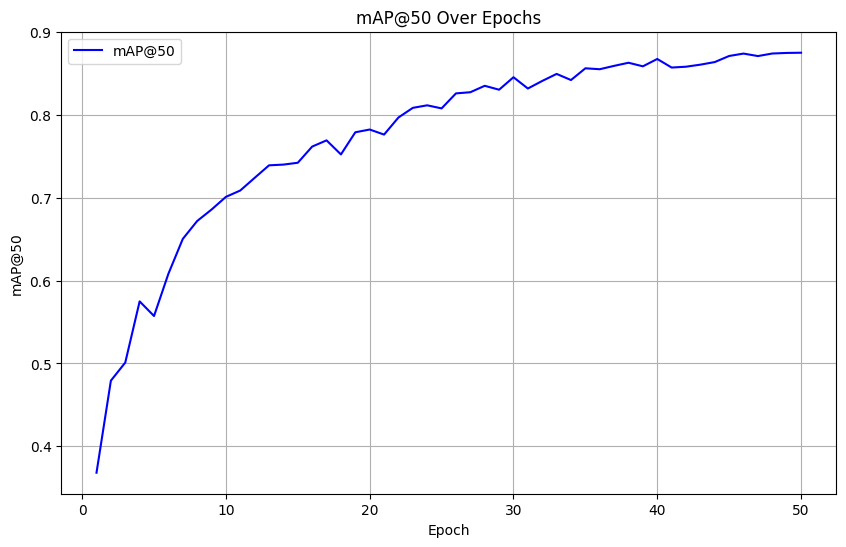

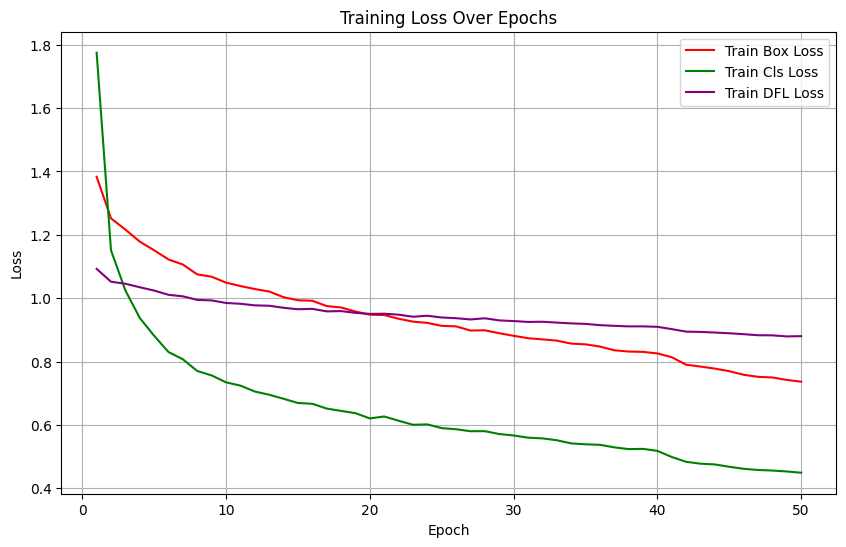

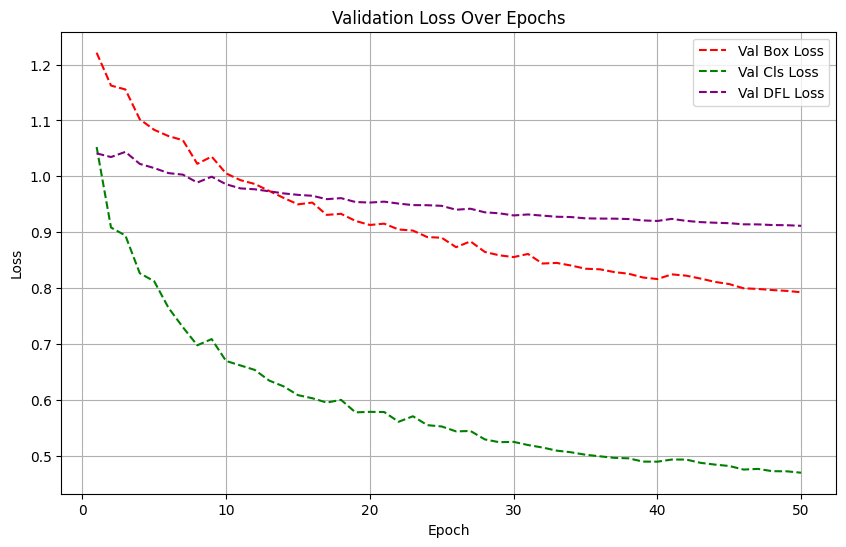

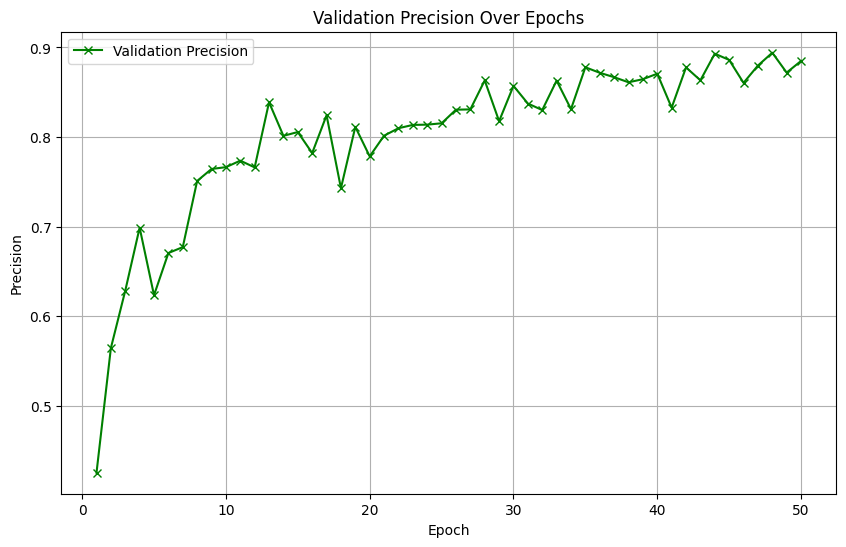

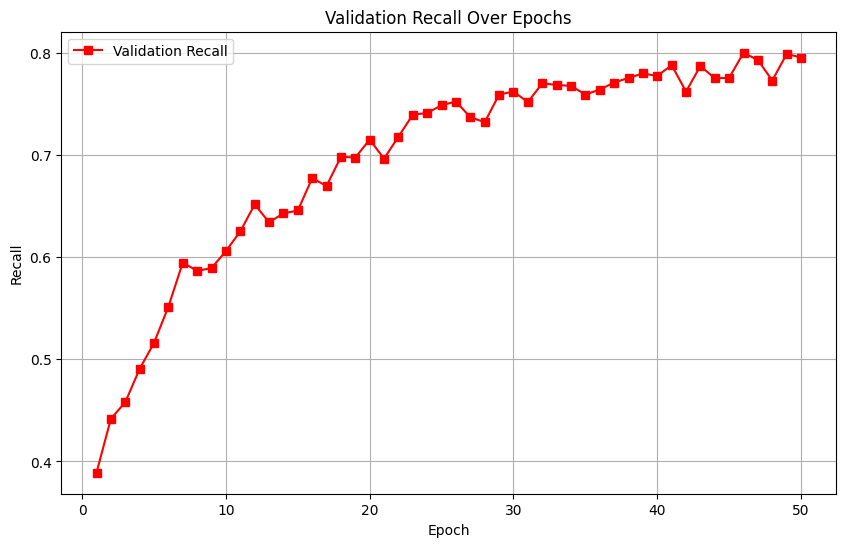

In [1]:
%matplotlib inline

from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os

# Loading pretrained YOLOv8n model
model = YOLO("runs/detect/kitti_yolov82/weights/best.pt")

# Path to the training results directory
results_path = "runs/detect/kitti_yolov82"
results_file = os.path.join(results_path, "results.csv")

# Loading and cleaning training metrics
metrics_df = pd.read_csv(results_file)
metrics_df.columns = [col.strip() for col in metrics_df.columns]

# Extracting metrics
epochs = metrics_df['epoch']
train_box_loss = metrics_df['train/box_loss']
train_cls_loss = metrics_df['train/cls_loss']
train_dfl_loss = metrics_df.get('train/dfl_loss', None)

val_mAP50 = metrics_df['metrics/mAP50(B)']
val_precision = metrics_df['metrics/precision(B)']
val_recall = metrics_df['metrics/recall(B)']

# mAP@50 Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_mAP50, label="mAP@50", color="blue")
plt.xlabel("Epoch")
plt.ylabel("mAP@50")
plt.title("mAP@50 Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Training Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_box_loss, label="Train Box Loss", color="red")
plt.plot(epochs, train_cls_loss, label="Train Cls Loss", color="green")
if train_dfl_loss is not None:
    plt.plot(epochs, train_dfl_loss, label="Train DFL Loss", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Validation Loss Plot
if 'val/box_loss' in metrics_df.columns and 'val/cls_loss' in metrics_df.columns:
    val_box_loss = metrics_df['val/box_loss']
    val_cls_loss = metrics_df['val/cls_loss']
    val_dfl_loss = metrics_df.get('val/dfl_loss', None)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_box_loss, label="Val Box Loss", color="red", linestyle="--")
    plt.plot(epochs, val_cls_loss, label="Val Cls Loss", color="green", linestyle="--")
    if val_dfl_loss is not None:
        plt.plot(epochs, val_dfl_loss, label="Val DFL Loss", color="purple", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Validation loss metrics not found in results.csv.")

# Precision Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precision, label="Validation Precision", color="green", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Validation Precision Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Recall Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_recall, label="Validation Recall", color="red", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Validation Recall Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Model Evaluation and Visualization 2
This cell evaluates the trained model on the validation set, computing Micro and Macro F1 scores, per-class F1 scores, and plotting ROC curves. It also displays the confusion matrix. 

**The F1 Scores are visible at the end of output**

Ultralytics 8.3.99  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_format\labels\val.cache... 1535 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1535/1535 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 96/96 [00:07<00:00, 12.79it/s]


                   all       1535       8345      0.886      0.797      0.873      0.663
                   Car       1371       5949      0.922      0.895      0.948      0.799
                   Van        436        581       0.92      0.866      0.937      0.768
                 Truck        199        211      0.967      0.957      0.983      0.828
            Pedestrian        353        904      0.907      0.642      0.807      0.493
        Person_sitting         21         55      0.765      0.591      0.664      0.448
               Cyclist        245        349      0.855      0.702      0.835      0.598
                  Tram         72        101      0.861      0.901      0.929      0.695
                  Misc        162        195      0.888      0.821      0.883      0.677
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val

image 1/1 d:\Software\VS Code\Term 2\Computer Vision\Final 4\kitti_dataset\yolo_for

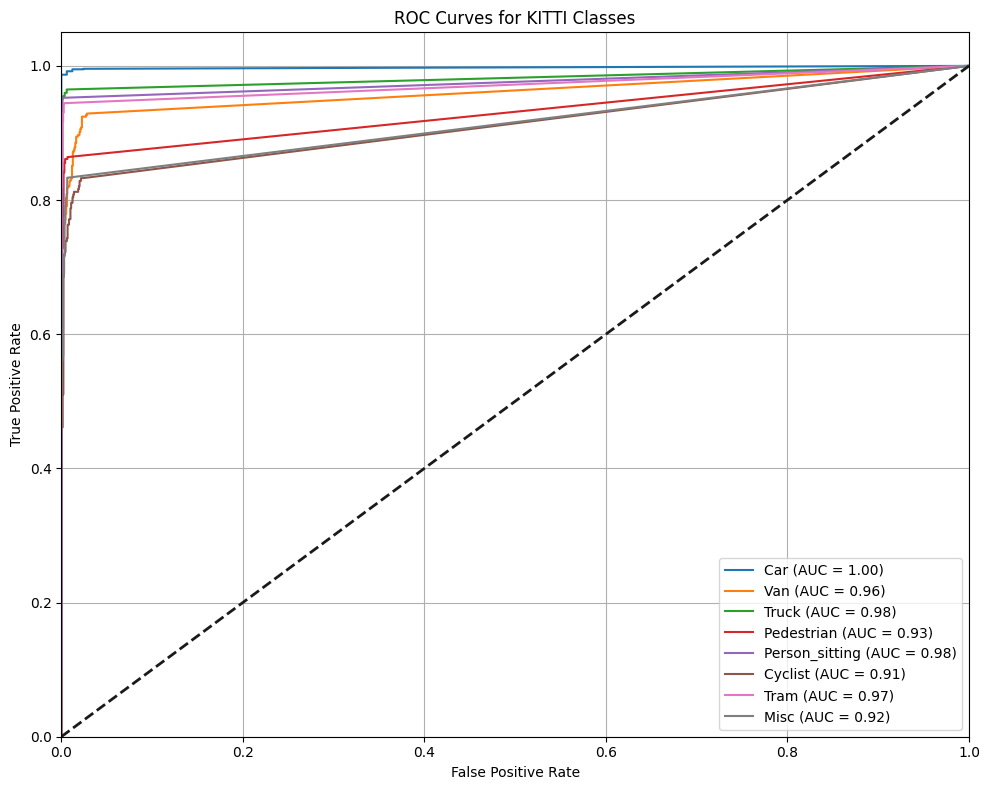

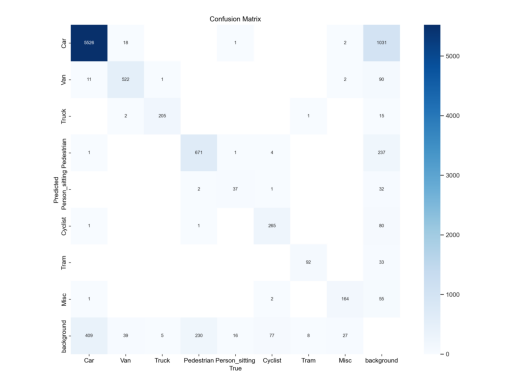

In [ ]:
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Loading the trained model
model = YOLO("runs/detect/kitti_yolov82/weights/best.pt")

# Validation data paths
val_images_dir = "kitti_dataset/yolo_format/images/val"
val_labels_dir = "kitti_dataset/yolo_format/labels/val"
class_names = ["Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram", "Misc"]
num_classes = len(class_names)

# Running validation
results = model.val(data="kitti_dataset/kitti.yaml", imgsz=640, batch=16, conf=0.25)

# Extracting ground truth and predictions
def get_ground_truth_and_predictions():
    y_true_all = []
    y_pred_all = []
    y_scores_all = []

    image_files = sorted(os.listdir(val_images_dir))
    for img_file in image_files:
        img_path = os.path.join(val_images_dir, img_file)
        label_file = os.path.join(val_labels_dir, img_file.replace(".png", ".txt"))

        # Ground truth
        gt_labels = set()
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                for line in f:
                    class_id = int(line.split()[0])
                    gt_labels.add(class_id)

        # Predictions
        result = model(img_path, imgsz=640, conf=0.25)[0]
        pred_classes = result.boxes.cls.cpu().numpy().astype(int)
        pred_scores = result.boxes.conf.cpu().numpy()

        y_true_img = [1 if cls in gt_labels else 0 for cls in range(num_classes)]
        y_pred_img = [1 if cls in pred_classes else 0 for cls in range(num_classes)]
        y_scores_img = [max([s for c, s in zip(pred_classes, pred_scores) if c == cls], default=0) 
                        for cls in range(num_classes)]

        y_true_all.append(y_true_img)
        y_pred_all.append(y_pred_img)
        y_scores_all.append(y_scores_img)

    return np.array(y_true_all), np.array(y_pred_all), np.array(y_scores_all)

# Get predictions
y_true, y_pred, y_scores = get_ground_truth_and_predictions()

# Micro F1 score
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
micro_f1 = f1_score(y_true_flat, y_pred_flat, average='micro')
print(f"Micro F1 Score: {micro_f1:.4f}")

# Macro F1 score
macro_f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

# F1 Score per class
f1_per_class = f1_score(y_true, y_pred, average=None)
print("\nF1 Score per Class:")
for cls, f1 in zip(class_names, f1_per_class):
    print(f"{cls}: {f1:.4f}")

# ROC Curves and AUC per class
plt.figure(figsize=(10, 8))
for cls in range(num_classes):
    y_true_cls = y_true[:, cls]
    y_scores_cls = y_scores[:, cls]
    fpr, tpr, _ = roc_curve(y_true_cls, y_scores_cls)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[cls]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for KITTI Classes")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

output_dir = "runs/detect/val"
cm_image_file = os.path.join(output_dir, "confusion_matrix.png")

# confusion matrix
if os.path.exists(cm_image_file):
    img = plt.imread(cm_image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("\nConfusion matrix not plotted.")

## Inference on Random Validation Images
This cell loads the trained model and performs inference on 10 randomly selected validation images, displaying the detection results with bounding boxes and class labels.


0: 640x640 6 Cars, 23.4ms
1: 640x640 4 Cars, 23.4ms
2: 640x640 1 Pedestrian, 23.4ms
3: 640x640 2 Cars, 1 Truck, 23.4ms
4: 640x640 2 Cars, 23.4ms
5: 640x640 5 Cars, 23.4ms
6: 640x640 7 Cars, 1 Truck, 23.4ms
7: 640x640 7 Cars, 24 Pedestrians, 1 Cyclist, 23.4ms
8: 640x640 3 Cars, 5 Pedestrians, 1 Cyclist, 23.4ms
9: 640x640 12 Cars, 23.4ms
Speed: 4.5ms preprocess, 23.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


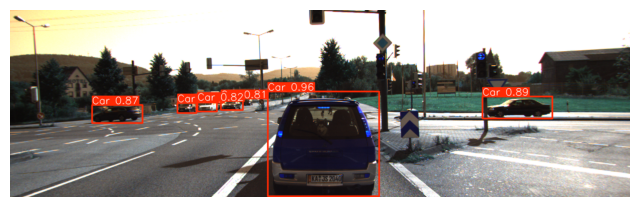

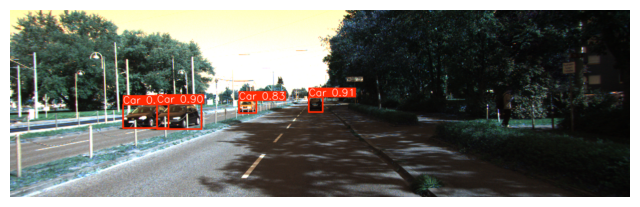

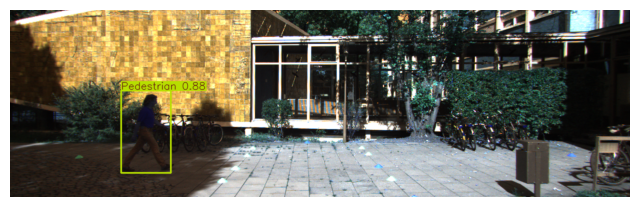

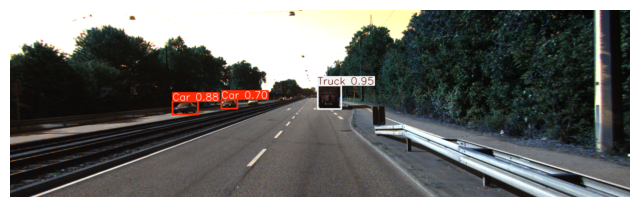

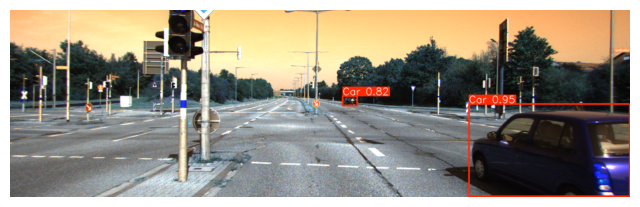

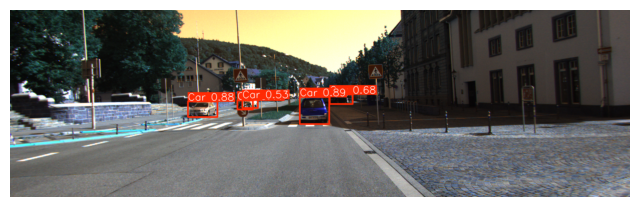

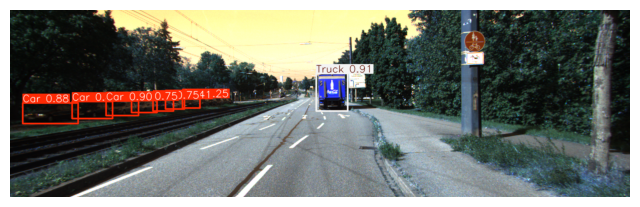

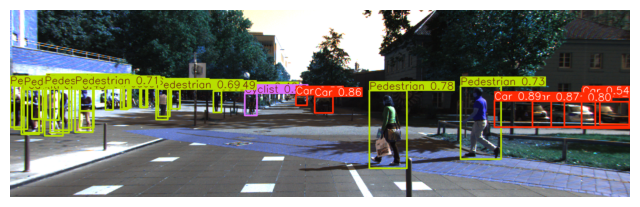

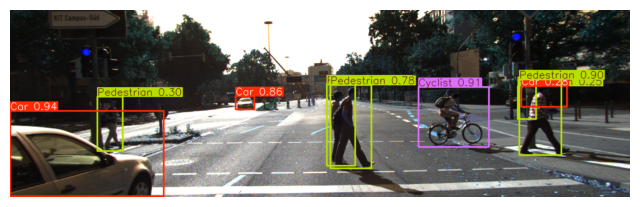

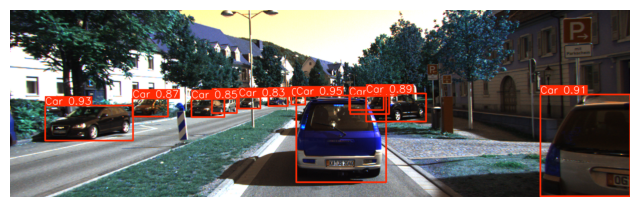

In [ ]:
from ultralytics import YOLO
import os
import random
import matplotlib.pyplot as plt

# Loading the trained model
model = YOLO("runs/detect/kitti_yolov82/weights/best.pt")

# Validation images directory
val_images_dir = "kitti_dataset/yolo_format/images/val"

# Getting all image files
all_images = [os.path.join(val_images_dir, img) for img in os.listdir(val_images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 10 images
random_images = random.sample(all_images, 10)

# Running inference
results = model.predict(source=random_images, imgsz=640, save=False)

for result in results:
    im_array = result.plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(im_array)
    plt.axis('off')
    plt.show()